In [26]:
import tweepy
from nltk.tokenize import word_tokenize
import re
import sys
import jsonpickle
import os
import json
from os import path
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords
import string

##Pull in tweets on topic of choice

def tweetPull(topic, follower_count_filter=200, total_tweets=2000):
    
    # Replace the API_KEY and API_SECRET with your application's key and secret.
    API_KEY = 'xxSAJCzdHduRpvNkqxWyFngwL'
    API_SECRET = 'oFaVN1sDSqPqwfcDZ7mdYNZ81KrpokYWvNPsZsesn4CZfB7vcP'

    #AppAuthHandler sets up app only auth for higher limits
    auth = tweepy.AppAuthHandler(API_KEY, API_SECRET)

    #wait_on_rate_limit automatically waits when limit is hit, and continues after
    api = tweepy.API(auth, wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)

    if (not api):
        print ("Can't Authenticate")
        sys.exit(-1)

    file_path = path.relpath("tweetScrapeTest.txt")
    
    searchQuery = topic  # this is what we're searching for
    maxTweets = total_tweets # Some arbitrary large number
    tweetsPerQry = 100  # this is the max the API permits
    
    # If results from a specific ID onwards are reqd, set since_id to that ID.
    # else default to no lower limit, go as far back as API allows
    sinceId = None

    # If results only below a specific ID are, set max_id to that ID.
    # else default to no upper limit, start from the most recent tweet matching the search query.
    max_id = -1L

    tweets = []
    tweetCount = 0
    print("Downloading max {0} tweets".format(maxTweets))
    with open(file_path, 'w') as f:
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry)
                    else:
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                for tweet in new_tweets:
                    if tweet._json['user']['followers_count'] > follower_count_filter and tweet._json['lang'] == 'en' and tweet._json['text'][0:2] != 'RT' and tweet._json['in_reply_to_status_id'] == None:
                        tweets.append(tweet._json)
                    #f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                            #'\n')
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id
            except tweepy.TweepError as e:
                # Just exit if any error
                print("some error : " + str(e))
                break
                
    return tweets
    print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, file_path))



In [27]:
def tweets_to_df(list_of_tweets):
    emoticons_str = r"""
        (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
        )"""

    regex_str = [
        emoticons_str,
        r'<[^>]+>', # HTML tags
        r'(?:@[\w_]+)', # @-mentions
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

        r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
        r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
        r'(?:[\w_]+)', # other words
        r'(?:\S)' # anything else
    ]

    tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
    emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

    def tokenize(s):
        return tokens_re.findall(s)

    def preprocess(s, lowercase=False):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        return tokens
    
    unicodeChars = [u"\u2026",u'\u2013',u'\u2019', u'\ud83d', u'\ude02', u'\u2605',u'\ud83c']
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['rt', 'via', 'bitcoin', 'btc'] + unicodeChars
        
    data = []
    temp = []
    hashes = []

    for item in list_of_tweets:
        cleaned_text_no_stops = []
        cleaned_text = preprocess(item['text'].lower())
        for word in cleaned_text:
            if word not in stop and not word.startswith(('#', '@', '&amp', 'http' )):
                cleaned_text_no_stops.append(word)
        pol = TextBlob(item['text']).sentiment.polarity
        
        temp.append(item['created_at'])
        temp.append(item['text'])
        if len(item['entities']['hashtags']) > 0:
            for i in item['entities']['hashtags']:
                hashes.append(i['text'])
        else:
            hashes = ''
        temp.append(hashes)
        temp.append((item['user']['name'], item['user']['screen_name']))
        temp.append(item['user']['followers_count'])
        temp.append(item['favorite_count'])
        temp.append(item['retweet_count'])
        temp.append(pol)
        temp.append(cleaned_text_no_stops)
        data.append(temp)
        temp = []
        hashes = []
    
    df = pd.DataFrame(data, columns=['timestamp','text','hashtags','user','user_followers','favorites','retweets','polarity','tokenized_text'])
    df['timestamp'] = pd.to_datetime(df.timestamp)
    return df
    
    

In [36]:
import seaborn as sns
import pandas as pd
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from nltk import bigrams
from collections import Counter
import numpy as np
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer

def dashboard(df, timeframe='1min', num_topics=3, word_per_topic=5, top_topics_count=5):
    negative = positive = neutral = 0
    for item in df.polarity:
        if item == 0:
            pass
        elif item < -.33:
            negative+=1
        elif item > .33:
            positive+=1
        else:
            neutral+=1
    sentiments = [negative, neutral, positive]
    names = ['negative', 'neutral', 'positive']
    
    idx = pd.DatetimeIndex(df.timestamp)
    polarity_scores = pd.Series(list(df.polarity), index=idx)
    pol_per_timeframe = polarity_scores.resample(timeframe,how='mean').fillna(0)

    non_neutral_sentiments = []
    for item in df.polarity:
        if 0 <= item <.1:
            pass
        else:
            non_neutral_sentiments.append(item)
    
    word_soup = []
    filter_words = ['amp']
    for item in df.tokenized_text:
        if item not in filter_words:
            word_soup = item+word_soup
        
    vectorizer = CountVectorizer()
    doc_term_matrix = vectorizer.fit_transform(word_soup).toarray()
    
    clf = decomposition.NMF(n_components=num_topics, random_state=1)
    
    doctopic = clf.fit_transform(doc_term_matrix)
    
    vocab = np.array(vectorizer.get_feature_names())

    topic_words = []
    
    for topic in clf.components_:
        word_idx = np.argsort(topic)[::-1][0:word_per_topic]
        topic_words.append([vocab[i] for i in word_idx])
        
    i = 1
    print 'NMF Topic Discovery:'
    for t in topic_words:
        print 'topic ' + str(i) + ': ' + ', '.join(t)
        i+=1
    
    count_all = Counter()
    count_all.update(word_soup)
    plotdata = count_all.most_common(top_topics_count)
    
    topics = zip(*plotdata)[0]
    mentions = zip(*plotdata)[1]
    x_pos = np.arange(len(topics)) 

    f, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(10,15))
    sns.distplot(non_neutral_sentiments, ax=ax2)
    sns.barplot(x=names, y=sentiments,ax=ax1)
    sns.tsplot(pol_per_timeframe,ax=ax3)
    sns.barplot(x=x_pos, y=mentions, ax=ax4)
    ax1.set_title('Sentiment Category vs Tweet Count')
    ax2.set_title('Sentiment Score Distribution (Neutrals Removed)')
    ax3.set_title('Aggregate Sentiment Over Time')
    ax4.set_title('Common topics by word count')
    ax4.set(xlabel='Topic',ylabel='# of mentions')
    ax4.xaxis.set_ticklabels(topics)
    f.subplots_adjust(hspace=.5)
    
    
    
    


Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1900 tweets
Downloaded 2000 tweets


/Users/connor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


NMF Topic Discovery:
topic 1: uber, schools, as, canoe, cool, triggering, cringe, ubers, take, gets
topic 2: left, stuff, ubers, free, regulator, code, ever, can, need, report
topic 3: people, ubers, call, bus, like, get, settles, driving, self, autonomous
topic 4: list, stuff, lyft, set, don, tests, cnet, record, you, ve
topic 5: make, lyft, rydengo, gets, ready, don, bus, ride, set, like


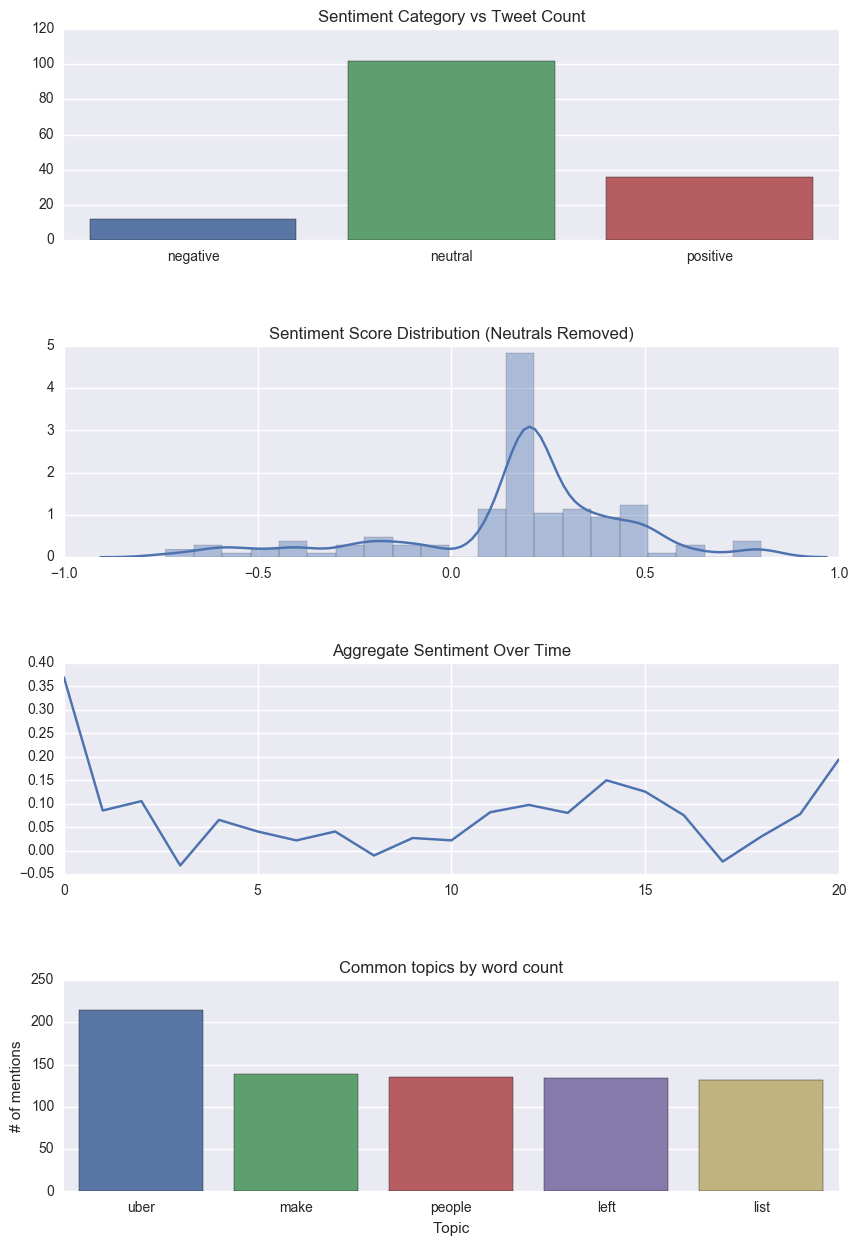

In [37]:
dashboard(tweets_to_df(tweetPull('uber',follower_count_filter=200,total_tweets=2000)),
          timeframe='1min',num_topics=5, word_per_topic=10)